CSC 180 Intelligent Systems (Fall 2021)

## Mount Google Drive
Use these functions to mount the drive hosting the data you wish to use.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defined functions

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import data from Drive
Importing th network intrutions data set and labeling it.

In [ ]:
import csv
import pandas as pd

# Importing the data
df_intrution = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project 2/network_intrusion_data.csv')

# Labeling each column
df_intrution.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
                        'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
                        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
                        'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
                        'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome' ] 
df_intrution

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


## Remove Duplicate lines
Removing duplicate lines to avoid overfitting.

In [ ]:
df_intrution = df_intrution.drop_duplicates()
df_intrution = df_intrution.reset_index(drop=True) # Resets index to avoid missing numbers
df_intrution

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,59,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145580,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
145581,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
145582,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
145583,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


## Normalize numeric values
This function needs to be corrected. it should be normalizing, but something seems to be going wrong.

Descrete values are either 1 or 0, so normalizing won't change them.

In [ ]:
encode_numeric_range(df_intrution, 'duration')
encode_numeric_range(df_intrution, 'src_bytes')
encode_numeric_range(df_intrution, 'dst_bytes')
encode_numeric_range(df_intrution, 'land')
encode_numeric_range(df_intrution, 'wrong_fragment')
encode_numeric_range(df_intrution, 'urgent')
encode_numeric_range(df_intrution, 'hot')
encode_numeric_range(df_intrution, 'num_failed_logins')
encode_numeric_range(df_intrution, 'logged_in')
encode_numeric_range(df_intrution, 'num_compromised')
encode_numeric_range(df_intrution, 'root_shell')
encode_numeric_range(df_intrution, 'su_attempted')
encode_numeric_range(df_intrution, 'num_root')
encode_numeric_range(df_intrution, 'num_file_creations')
encode_numeric_range(df_intrution, 'num_shells')
encode_numeric_range(df_intrution, 'num_access_files')
encode_numeric_range(df_intrution, 'num_outbound_cmds')
encode_numeric_range(df_intrution, 'is_host_login')
encode_numeric_range(df_intrution, 'is_guest_login')
encode_numeric_range(df_intrution, 'count')
encode_numeric_range(df_intrution, 'srv_count')
encode_numeric_range(df_intrution, 'serror_rate')
encode_numeric_range(df_intrution, 'srv_serror_rate')
encode_numeric_range(df_intrution, 'rerror_rate')
encode_numeric_range(df_intrution, 'srv_rerror_rate')
encode_numeric_range(df_intrution, 'same_srv_rate')
encode_numeric_range(df_intrution, 'diff_srv_rate')
encode_numeric_range(df_intrution, 'srv_diff_host_rate')
encode_numeric_range(df_intrution, 'dst_host_count')
encode_numeric_range(df_intrution, 'dst_host_srv_count')
encode_numeric_range(df_intrution, 'dst_host_same_srv_rate')
encode_numeric_range(df_intrution, 'dst_host_diff_srv_rate')
encode_numeric_range(df_intrution, 'dst_host_same_src_port_rate')
encode_numeric_range(df_intrution, 'dst_host_srv_diff_host_rate')
encode_numeric_range(df_intrution, 'dst_host_serror_rate')
encode_numeric_range(df_intrution, 'dst_host_srv_serror_rate')
encode_numeric_range(df_intrution, 'dst_host_rerror_rate')
encode_numeric_range(df_intrution, 'dst_host_srv_rerror_rate')
df_intrution

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0.0,tcp,http,SF,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015656,0.015656,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.074510,0.074510,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0.0,tcp,http,SF,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015656,0.015656,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.113725,0.113725,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0.0,tcp,http,SF,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.152941,0.152941,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0.0,tcp,http,SF,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.192157,0.192157,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0.0,tcp,http,SF,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.231373,0.231373,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145580,0.0,tcp,http,SF,4.470881e-07,0.000365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.007828,0.009785,0.00,0.00,0.0,0.0,1.0,0.0,0.40,0.337255,1.000000,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
145581,0.0,tcp,http,SF,4.067060e-07,0.000443,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.023529,1.000000,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
145582,0.0,tcp,http,SF,2.927706e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.035225,0.17,0.11,0.0,0.0,1.0,0.0,0.17,0.062745,1.000000,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
145583,0.0,tcp,http,SF,4.196859e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.023483,0.00,0.00,0.0,0.0,1.0,0.0,0.17,0.101961,1.000000,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [ ]:
encode_text_dummy(df_intrution, "protocol_type")
encode_text_dummy(df_intrution, "service")
encode_text_dummy(df_intrution, "flag")
df_intrution

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,...,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015656,0.015656,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.074510,0.074510,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.015656,0.015656,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.113725,0.113725,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.152941,0.152941,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.192157,0.192157,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.231373,0.231373,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145580,0.0,4.470881e-07,0.000365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.007828,0.009785,0.00,0.00,0.0,0.0,1.0,0.0,0.40,0.337255,1.000000,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
145581,0.0,4.067060e-07,0.000443,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.023529,1.000000,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
145582,0.0,2.927706e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.035225,0.17,0.11,0.0,0.0,1.0,0.0,0.17,0.062745,1.000000,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
145583,0.0,4.196859e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.011742,0.023483,0.00,0.00,0.0,0.0,1.0,0.0,0.17,0.101961,1.000000,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.,0,...,0,0,

## Remove columns with missing Values

In [ ]:
df_intrution = df_intrution.dropna(axis='columns')
df_intrution

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,...,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.074510,0.074510,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.015656,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.113725,0.113725,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.152941,0.152941,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.192157,0.192157,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.231373,0.231373,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145580,0.0,4.470881e-07,0.000365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007828,0.009785,0.00,0.00,0.0,0.0,1.0,0.0,0.40,0.337255,1.000000,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
145581,0.0,4.067060e-07,0.000443,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.011742,0.00,0.00,0.0,0.0,1.0,0.0,0.00,0.023529,1.000000,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
145582,0.0,2.927706e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.035225,0.17,0.11,0.0,0.0,1.0,0.0,0.17,0.062745,1.000000,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
145583,0.0,4.196859e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011742,0.023483,0.00,0.00,0.0,0.0,1.0,0.0,0.17,0.101961,1.000000,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Checking outcome types

In [ ]:
df_outcome = df_intrution.drop_duplicates(subset='outcome')
df_outcome = df_outcome.reset_index(drop=True) # Resets index to avoid missing numbers
df_outcome['outcome']

0              normal.
1     buffer_overflow.
2          loadmodule.
3                perl.
4             neptune.
5               smurf.
6        guess_passwd.
7                 pod.
8            teardrop.
9           portsweep.
10            ipsweep.
11               land.
12          ftp_write.
13               back.
14               imap.
15              satan.
16                phf.
17               nmap.
18           multihop.
19        warezmaster.
20        warezclient.
21                spy.
22            rootkit.
Name: outcome, dtype: object

## Defining Encode funtion for outcome column
Turning all normal values to 0 and every other value to 1

In [ ]:
# create a function that encodes outcome column of dataset
def network_outcome_encoder(x):
    if x == "normal.":
        return 0
    else:
        return 1

## Creating encoded outcome array.

In [ ]:
df_outcome_encoded = df_intrution['outcome'].apply(network_outcome_encoder)
df_outcome_encoded
#df_intrution['outcome'] = df_intrution['outcome'].map(network_outcome_encoder)

0         0
1         0
2         0
3         0
4         0
         ..
145580    0
145581    0
145582    0
145583    0
145584    0
Name: outcome, Length: 145585, dtype: int64

## Swapping outcome column for encoded outcome array.

In [ ]:
df_intrution['outcome'] = df_outcome_encoded
df_intrution['outcome']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0         0
1         0
2         0
3         0
4         0
         ..
145580    0
145581    0
145582    0
145583    0
145584    0
Name: outcome, Length: 145585, dtype: int64

In [ ]:
df_intrution.shape

(145585, 117)

## Checking dataset outcome column
Checking to see if swap was a success.

In [ ]:
df_outcome = df_intrution.drop_duplicates(subset='outcome')
df_outcome = df_outcome.reset_index(drop=True) # Resets index to avoid missing numbers
df_outcome['outcome']

0    0
1    1
Name: outcome, dtype: int64

# **stop here for now**

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Encode to a 2D matrix for training
x = df_intrution.drop('outcome', axis='columns').to_numpy()
y = df_intrution['outcome'].to_numpy()

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (116468, 116)
Shape of y_train: (116468,)

Shape of x_test: (29117, 116)
Shape of y_test: (29117,)


In [ ]:
# define input image dimensions
img_rows, img_cols = 1, 116

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

print(x_train.shape)
print(x_test.shape)

(116468, 1, 116, 1)
(29117, 1, 116, 1)


In [ ]:
num_classes = 2

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
pd.DataFrame(y_train)

,0,1
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
116463,0.0,1.0
116464,0.0,1.0
116465,0.0,1.0
116466,0.0,1.0


In [ ]:
pd.DataFrame(y_test)

,0,1
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
...,...,...
29112,0.0,1.0
29113,0.0,1.0
29114,0.0,1.0
29115,0.0,1.0


In [ ]:
y_train.shape, y_test.shape

((116468, 2), (29117, 2))

## Convelusional Neural Network

## Activation = Relu, Optimizer = adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 1000 neurons
Accuracy: 0.9985575437029914

Averaged F1: 0.9985574573441822

Time: 1m 38s


0
Epoch 1/200
389/389 - 2s - loss: 0.0544 - accuracy: 0.9834 - val_loss: 0.0271 - val_accuracy: 0.9898

Epoch 00001: val_loss improved from inf to 0.02713, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0235 - accuracy: 0.9920 - val_loss: 0.0097 - val_accuracy: 0.9980

Epoch 00002: val_loss improved from 0.02713 to 0.00969, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0081 - val_accuracy: 0.9978

Epoch 00003: val_loss improved from 0.00969 to 0.00805, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0079 - val_accuracy: 0.9976

Epoch 00004: val_loss improved from 0.00805 to 0.00786, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 2s - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.0068 - val_accuracy: 0.9977

Epoch 00005: val_loss improved from 0.00786 to 0.00675, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

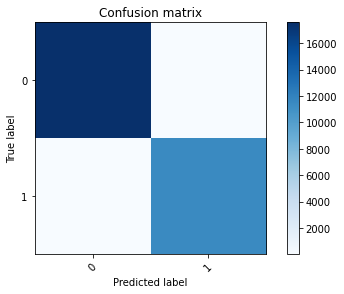

Accuracy: 0.9985575437029914
Averaged F1: 0.9985574573441822
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Sigmoid, Optimizer = adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 1000 neurons


Accuracy: 0.9981797575299654

Averaged F1: 0.9981796621925855

Time: 5m 47s

0
Epoch 1/200
389/389 - 2s - loss: 0.4635 - accuracy: 0.7680 - val_loss: 0.1083 - val_accuracy: 0.9691

Epoch 00001: val_loss improved from inf to 0.10831, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.1213 - accuracy: 0.9632 - val_loss: 0.0844 - val_accuracy: 0.9739

Epoch 00002: val_loss improved from 0.10831 to 0.08436, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0990 - accuracy: 0.9709 - val_loss: 0.0709 - val_accuracy: 0.9827

Epoch 00003: val_loss improved from 0.08436 to 0.07090, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0864 - accuracy: 0.9752 - val_loss: 0.0667 - val_accuracy: 0.9825

Epoch 00004: val_loss improved from 0.07090 to 0.06670, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0776 - accuracy: 0.9780 - val_loss: 0.0569 - val_accuracy: 0.9846

Epoch 00005: val_loss improved from 0.06670 to 0.05688, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

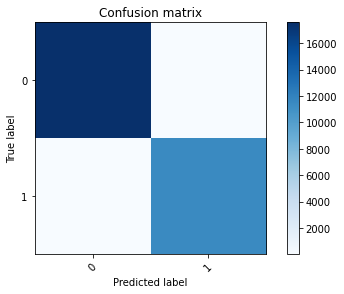

Accuracy: 0.9981797575299654
Averaged F1: 0.9981796621925855
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:

# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                    activation='sigmoid', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='sigmoid', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='sigmoid'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Tanh, Optimizer = adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 1000 neurons

Accurary: 0.9985918879005392

Average F1: 0.9985919404666145

Time: 1m 34s


0
Epoch 1/200
389/389 - 2s - loss: 0.0555 - accuracy: 0.9831 - val_loss: 0.0343 - val_accuracy: 0.9886

Epoch 00001: val_loss improved from inf to 0.03425, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.0393 - accuracy: 0.9869 - val_loss: 0.0242 - val_accuracy: 0.9915

Epoch 00002: val_loss improved from 0.03425 to 0.02415, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0328 - accuracy: 0.9891 - val_loss: 0.0266 - val_accuracy: 0.9897

Epoch 00003: val_loss did not improve from 0.02415
Epoch 4/200
389/389 - 1s - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.0160 - val_accuracy: 0.9936

Epoch 00004: val_loss improved from 0.02415 to 0.01602, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 2s - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0136 - val_accuracy: 0.9956

Epoch 00005: val_loss improved from 0.01602 to 0.01358, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 2s - loss: 0.0235 - accuracy: 0.9926 - val_

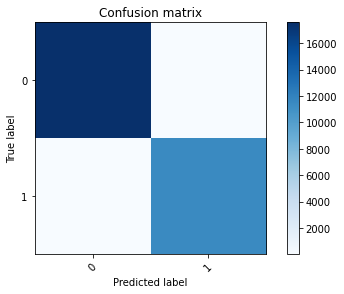

Accuracy: 0.9985918879005392
Averaged F1: 0.9985919404666145
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                    activation='tanh', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='tanh', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='tanh'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = SGD
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 1000 neurons
8m 15s

Accuracy: 0.9892159219699832

Averaged F1: 0.9892098788985679

0
Epoch 1/200
389/389 - 2s - loss: 0.2697 - accuracy: 0.9480 - val_loss: 0.1143 - val_accuracy: 0.9694

Epoch 00001: val_loss improved from inf to 0.11432, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.1114 - accuracy: 0.9695 - val_loss: 0.0937 - val_accuracy: 0.9746

Epoch 00002: val_loss improved from 0.11432 to 0.09370, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0959 - accuracy: 0.9749 - val_loss: 0.0821 - val_accuracy: 0.9793

Epoch 00003: val_loss improved from 0.09370 to 0.08214, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0864 - accuracy: 0.9776 - val_loss: 0.0744 - val_accuracy: 0.9823

Epoch 00004: val_loss improved from 0.08214 to 0.07439, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0804 - accuracy: 0.9793 - val_loss: 0.0695 - val_accuracy: 0.9825

Epoch 00005: val_loss improved from 0.07439 to 0.06954, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

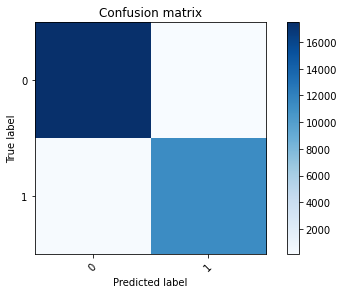

Accuracy: 0.9892159219699832
Averaged F1: 0.9892098788985679
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17589
           1       0.99      0.98      0.99     11528

    accuracy                           0.99     29117
   macro avg       0.99      0.99      0.99     29117
weighted avg       0.99      0.99      0.99     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Testing on differnet numbers of layer and neuron

## Activation = Relu, Optimizer = adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 10 neurons

Accuracy: 0.9987292646907305

Average F1 score: 0.998729140952868

Time: 1m 36s


0
Epoch 1/200
389/389 - 2s - loss: 0.0547 - accuracy: 0.9834 - val_loss: 0.0275 - val_accuracy: 0.9908

Epoch 00001: val_loss improved from inf to 0.02752, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0250 - accuracy: 0.9917 - val_loss: 0.0106 - val_accuracy: 0.9968

Epoch 00002: val_loss improved from 0.02752 to 0.01061, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0149 - accuracy: 0.9951 - val_loss: 0.0086 - val_accuracy: 0.9973

Epoch 00003: val_loss improved from 0.01061 to 0.00864, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 2s - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.0095 - val_accuracy: 0.9972

Epoch 00004: val_loss did not improve from 0.00864
Epoch 5/200
389/389 - 1s - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.0072 - val_accuracy: 0.9977

Epoch 00005: val_loss improved from 0.00864 to 0.00717, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 2s - loss: 0.0100 - accuracy: 0.9970 - val_

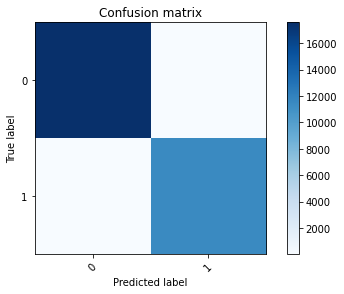

Accuracy: 0.9987292646907305
Averaged F1: 0.998729140952868
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D( 32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 500 neurons

Accuracy: 0.9987636088882783

Average Score F1: 0.9987636273604831

Time: 1m 38s

0
Epoch 1/200
389/389 - 2s - loss: 0.0562 - accuracy: 0.9837 - val_loss: 0.0294 - val_accuracy: 0.9907

Epoch 00001: val_loss improved from inf to 0.02937, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0143 - val_accuracy: 0.9953

Epoch 00002: val_loss improved from 0.02937 to 0.01434, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.0107 - val_accuracy: 0.9967

Epoch 00003: val_loss improved from 0.01434 to 0.01068, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0085 - val_accuracy: 0.9972

Epoch 00004: val_loss improved from 0.01068 to 0.00853, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0073 - val_accuracy: 0.9981

Epoch 00005: val_loss improved from 0.00853 to 0.00731, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

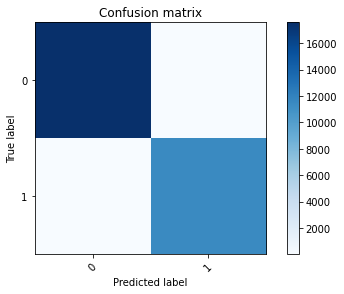

Accuracy: 0.9987636088882783
Averaged F1: 0.9987636273604831
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 10 neurons
## Layer 1 : 10 neurons

Accuracy: 0.9984888553078958

Averaged F1: 0.9984889905269724

Time: 1m 56s

0
Epoch 1/200
389/389 - 2s - loss: 0.0962 - accuracy: 0.9702 - val_loss: 0.0468 - val_accuracy: 0.9872

Epoch 00001: val_loss improved from inf to 0.04684, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.0491 - accuracy: 0.9849 - val_loss: 0.0355 - val_accuracy: 0.9869

Epoch 00002: val_loss improved from 0.04684 to 0.03550, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0386 - accuracy: 0.9873 - val_loss: 0.0255 - val_accuracy: 0.9917

Epoch 00003: val_loss improved from 0.03550 to 0.02553, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0301 - accuracy: 0.9897 - val_loss: 0.0168 - val_accuracy: 0.9941

Epoch 00004: val_loss improved from 0.02553 to 0.01677, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0113 - val_accuracy: 0.9966

Epoch 00005: val_loss improved from 0.01677 to 0.01131, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

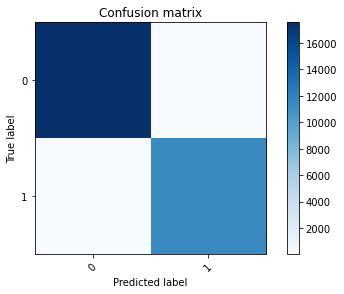

Accuracy: 0.9984888553078958
Averaged F1: 0.9984889905269724
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 500 neurons
## Layer 1 : 500 neurons

Accuracy: 0.9985918879005392

Averaged F1: 0.9985918984213269

Time: 1m 26s


0
Epoch 1/200
389/389 - 2s - loss: 0.0540 - accuracy: 0.9838 - val_loss: 0.0241 - val_accuracy: 0.9915

Epoch 00001: val_loss improved from inf to 0.02413, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0093 - val_accuracy: 0.9975

Epoch 00002: val_loss improved from 0.02413 to 0.00927, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0078 - val_accuracy: 0.9975

Epoch 00003: val_loss improved from 0.00927 to 0.00780, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0116 - accuracy: 0.9961 - val_loss: 0.0073 - val_accuracy: 0.9977

Epoch 00004: val_loss improved from 0.00780 to 0.00733, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0108 - accuracy: 0.9965 - val_loss: 0.0069 - val_accuracy: 0.9979

Epoch 00005: val_loss improved from 0.00733 to 0.00694, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

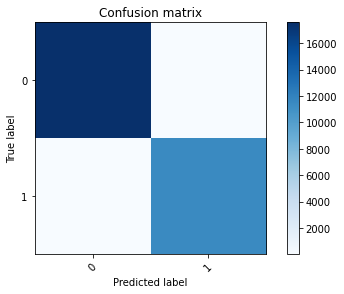

Accuracy: 0.9985918879005392
Averaged F1: 0.9985918984213269
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 32  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 1000 neurons
## Layer 1 : 1000 neurons

Accuracy: 0.998626232098087 

Averaged F1: 0.9986261910044079

Time: 1m 42s

0
Epoch 1/200
389/389 - 2s - loss: 0.0524 - accuracy: 0.9841 - val_loss: 0.0283 - val_accuracy: 0.9910

Epoch 00001: val_loss improved from inf to 0.02828, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0243 - accuracy: 0.9920 - val_loss: 0.0107 - val_accuracy: 0.9966

Epoch 00002: val_loss improved from 0.02828 to 0.01072, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0085 - val_accuracy: 0.9972

Epoch 00003: val_loss improved from 0.01072 to 0.00845, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 2s - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0074 - val_accuracy: 0.9979

Epoch 00004: val_loss improved from 0.00845 to 0.00745, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 2s - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.0061 - val_accuracy: 0.9979

Epoch 00005: val_loss improved from 0.00745 to 0.00610, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

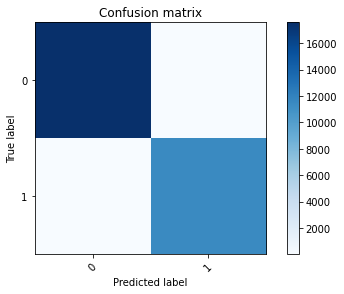

Accuracy: 0.998626232098087
Averaged F1: 0.9986261910044079
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 128  neurons, size = 3
## Kernel 2: 64  neurons, size = 3
## Layer 1 : 1000 neurons

Accuracy: 0.9989353298760174

Averaged F1: 0.9989353059946118

Time: 1m 54s

0
Epoch 1/200
389/389 - 3s - loss: 0.0519 - accuracy: 0.9853 - val_loss: 0.0226 - val_accuracy: 0.9926

Epoch 00001: val_loss improved from inf to 0.02261, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0109 - val_accuracy: 0.9961

Epoch 00002: val_loss improved from 0.02261 to 0.01093, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0123 - accuracy: 0.9963 - val_loss: 0.0062 - val_accuracy: 0.9981

Epoch 00003: val_loss improved from 0.01093 to 0.00621, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 2s - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.0064 - val_accuracy: 0.9978

Epoch 00004: val_loss did not improve from 0.00621
Epoch 5/200
389/389 - 2s - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0058 - val_accuracy: 0.9981

Epoch 00005: val_loss improved from 0.00621 to 0.00580, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 2s - loss: 0.0082 - accuracy: 0.9975 - val_

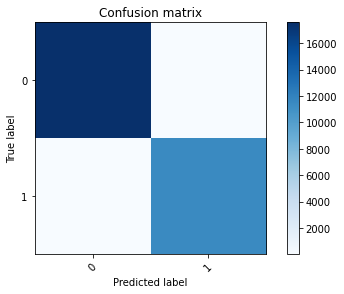

Accuracy: 0.9989353298760174
Averaged F1: 0.9989353059946118
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (128, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 500  neurons, size = 3
## Kernel 2: 250  neurons, size = 3
## Layer 1 : 1000 neurons

Accuracy: 0.9991413950613044

Averaged F1: 0.9991413500908423

Time: 7m 51s

0
Epoch 1/200
389/389 - 7s - loss: 0.0414 - accuracy: 0.9872 - val_loss: 0.0230 - val_accuracy: 0.9948

Epoch 00001: val_loss improved from inf to 0.02304, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 7s - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0069 - val_accuracy: 0.9978

Epoch 00002: val_loss improved from 0.02304 to 0.00693, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 7s - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0080 - val_accuracy: 0.9976

Epoch 00003: val_loss did not improve from 0.00693
Epoch 4/200
389/389 - 7s - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0072 - val_accuracy: 0.9975

Epoch 00004: val_loss did not improve from 0.00693
Epoch 5/200
389/389 - 7s - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0065 - val_accuracy: 0.9982

Epoch 00005: val_loss improved from 0.00693 to 0.00653, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 7s - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0059 - val_accuracy: 0.9980

Epoch 

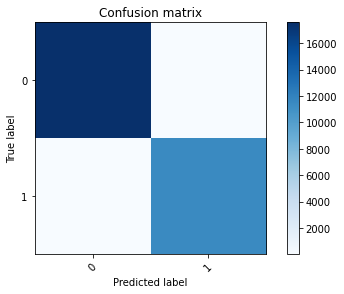

Accuracy: 0.9989696740735653
Averaged F1: 0.9989696123887016
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (500, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(250, (1, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 32   neurons, size = 3
## Layer 1 : 1000 neurons

Accuracy: 0.9986949204931826

Averaged F1: 0.9986949204931826

Time: 1m 16s

0
Epoch 1/200
389/389 - 2s - loss: 0.0468 - accuracy: 0.9862 - val_loss: 0.0160 - val_accuracy: 0.9954

Epoch 00001: val_loss improved from inf to 0.01602, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.0163 - accuracy: 0.9948 - val_loss: 0.0089 - val_accuracy: 0.9972

Epoch 00002: val_loss improved from 0.01602 to 0.00891, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0070 - val_accuracy: 0.9980

Epoch 00003: val_loss improved from 0.00891 to 0.00700, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.0063 - val_accuracy: 0.9984

Epoch 00004: val_loss improved from 0.00700 to 0.00629, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.0065 - val_accuracy: 0.9980

Epoch 00005: val_loss did not improve from 0.00629
Epoch 6/200
389/389 - 1s - loss: 0.0080 - accuracy: 0.9976 - val_

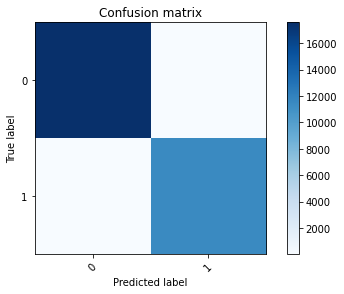

Accuracy: 0.9986949204931826
Averaged F1: 0.9986949204931826
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (32, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 128  neurons, size = 3
## Layer 1 : 1000 neurons

Accuracy: 0.9987979530858262

Averaged F1: 0.9987979800196098

Time: 1m 57s

0
Epoch 1/200
389/389 - 3s - loss: 0.0380 - accuracy: 0.9882 - val_loss: 0.0127 - val_accuracy: 0.9958

Epoch 00001: val_loss improved from inf to 0.01272, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0074 - val_accuracy: 0.9978

Epoch 00002: val_loss improved from 0.01272 to 0.00738, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0059 - val_accuracy: 0.9983

Epoch 00003: val_loss improved from 0.00738 to 0.00587, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 2s - loss: 0.0078 - accuracy: 0.9977 - val_loss: 0.0060 - val_accuracy: 0.9984

Epoch 00004: val_loss did not improve from 0.00587
Epoch 5/200
389/389 - 2s - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0053 - val_accuracy: 0.9985

Epoch 00005: val_loss improved from 0.00587 to 0.00532, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 2s - loss: 0.0072 - accuracy: 0.9979 - val_

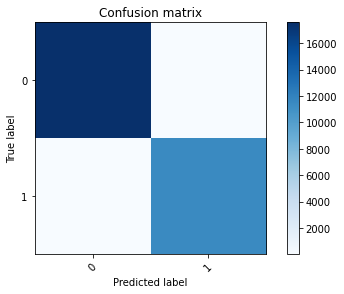

Accuracy: 0.9987979530858262
Averaged F1: 0.9987979800196098
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (128, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 500  neurons, size = 3
## Layer 1 : 1000 neurons

Accuracy: 0.9989353298760174

Averaged F1: 0.9989352900593563

Time: 2m 11s


0
Epoch 1/200
389/389 - 3s - loss: 0.0382 - accuracy: 0.9876 - val_loss: 0.0152 - val_accuracy: 0.9955

Epoch 00001: val_loss improved from inf to 0.01516, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0130 - accuracy: 0.9962 - val_loss: 0.0080 - val_accuracy: 0.9979

Epoch 00002: val_loss improved from 0.01516 to 0.00803, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.0076 - val_accuracy: 0.9981

Epoch 00003: val_loss improved from 0.00803 to 0.00765, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 2s - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0058 - val_accuracy: 0.9986

Epoch 00004: val_loss improved from 0.00765 to 0.00576, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 2s - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0058 - val_accuracy: 0.9985

Epoch 00005: val_loss improved from 0.00576 to 0.00576, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

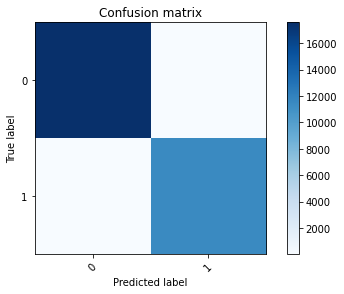

Accuracy: 0.9989353298760174
Averaged F1: 0.9989352900593563
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D (128, kernel_size=(1, 3), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = Adam
## Kernel 1: 32  neurons, size = 2
## Kernel 2: 64  neurons, size = 2
## Layer 1 : 1000 neurons

Accuracy: 0.9984888553078958

Averaged F1: 0.9984888553078958

Time: 1m 56s

0
Epoch 1/200
389/389 - 2s - loss: 0.0598 - accuracy: 0.9821 - val_loss: 0.0330 - val_accuracy: 0.9895

Epoch 00001: val_loss improved from inf to 0.03305, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 1s - loss: 0.0271 - accuracy: 0.9913 - val_loss: 0.0144 - val_accuracy: 0.9950

Epoch 00002: val_loss improved from 0.03305 to 0.01435, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 1s - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0106 - val_accuracy: 0.9971

Epoch 00003: val_loss improved from 0.01435 to 0.01062, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 1s - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.0084 - val_accuracy: 0.9974

Epoch 00004: val_loss improved from 0.01062 to 0.00836, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 1s - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.0080 - val_accuracy: 0.9974

Epoch 00005: val_loss improved from 0.00836 to 0.00802, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

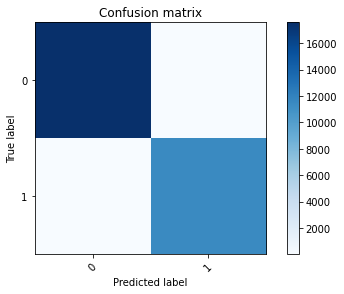

Accuracy: 0.9984888553078958
Averaged F1: 0.9984888553078958
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))


## Activation = Relu, Optimizer = Adam
## Kernel 1: 32  neurons, size = 5
## Kernel 2: 64  neurons, size = 5
## Layer 1 : 1000 neurons

Accuracy: 0.9989009856784696

Averaged F1: 0.9989009528035263

Time: 1m 37s

0
Epoch 1/200
389/389 - 2s - loss: 0.0520 - accuracy: 0.9832 - val_loss: 0.0284 - val_accuracy: 0.9897

Epoch 00001: val_loss improved from inf to 0.02844, saving model to dnn/best_weights.hdf5
Epoch 2/200
389/389 - 2s - loss: 0.0206 - accuracy: 0.9933 - val_loss: 0.0086 - val_accuracy: 0.9970

Epoch 00002: val_loss improved from 0.02844 to 0.00858, saving model to dnn/best_weights.hdf5
Epoch 3/200
389/389 - 2s - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0071 - val_accuracy: 0.9977

Epoch 00003: val_loss improved from 0.00858 to 0.00711, saving model to dnn/best_weights.hdf5
Epoch 4/200
389/389 - 2s - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0064 - val_accuracy: 0.9978

Epoch 00004: val_loss improved from 0.00711 to 0.00644, saving model to dnn/best_weights.hdf5
Epoch 5/200
389/389 - 2s - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.0058 - val_accuracy: 0.9980

Epoch 00005: val_loss improved from 0.00644 to 0.00584, saving model to dnn/best_weights.hdf5
Epoch 6/200
389/389 - 

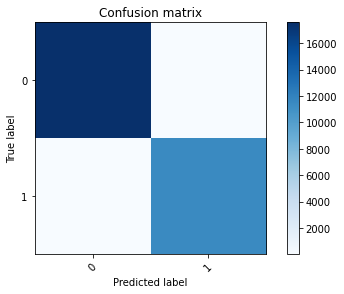

Accuracy: 0.9989009856784696
Averaged F1: 0.9989009528035263
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1, 5), strides=(1, 1),
                    activation='relu', padding='same',
                    input_shape=(1, 116, 1)))
    model.add(MaxPooling2D(pool_size=(1,2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # define optimizer and objective, compile cnn
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=300, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Fully Connected Models

In [ ]:
# Encode to a 2D matrix for training
x = df_intrution.drop('outcome', axis='columns').to_numpy()
y = df_intrution['outcome'].to_numpy()

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
num_classes = 2

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## Activation = Relu, Optimizer = adam
## Layer 1 : 100 neurons
## Layer 2:  500 neurons

41s

Accuracy: 0.9989009856784696

Averaged F1: 0.9989009528035263


0
Epoch 1/200
167/167 - 1s - loss: 0.0228 - accuracy: 0.9801 - val_loss: 0.0072 - val_accuracy: 0.9914

Epoch 00001: val_loss improved from inf to 0.00723, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0061 - accuracy: 0.9922 - val_loss: 0.0047 - val_accuracy: 0.9936

Epoch 00002: val_loss improved from 0.00723 to 0.00474, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0040 - accuracy: 0.9957 - val_loss: 0.0030 - val_accuracy: 0.9973

Epoch 00003: val_loss improved from 0.00474 to 0.00298, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0027 - accuracy: 0.9979 - val_loss: 0.0021 - val_accuracy: 0.9982

Epoch 00004: val_loss improved from 0.00298 to 0.00208, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0020 - accuracy: 0.9982 - val_loss: 0.0019 - val_accuracy: 0.9984

Epoch 00005: val_loss improved from 0.00208 to 0.00192, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

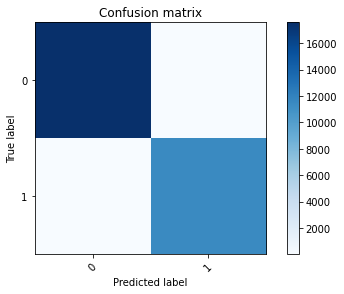

Accuracy: 0.9989009856784696
Averaged F1: 0.9989009528035263
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Tanh, Optimizer = adam
## Layer 1 : 100 neurons
## Layer 2:  500 neurons

47s

Accuracy: 0.9985575437029914
Averaged F1: 0.9985575221365692

0
Epoch 1/200
167/167 - 1s - loss: 0.0191 - accuracy: 0.9843 - val_loss: 0.0086 - val_accuracy: 0.9914

Epoch 00001: val_loss improved from inf to 0.00855, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0074 - accuracy: 0.9910 - val_loss: 0.0060 - val_accuracy: 0.9920

Epoch 00002: val_loss improved from 0.00855 to 0.00605, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0054 - accuracy: 0.9927 - val_loss: 0.0055 - val_accuracy: 0.9938

Epoch 00003: val_loss improved from 0.00605 to 0.00546, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0038 - accuracy: 0.9967 - val_loss: 0.0029 - val_accuracy: 0.9981

Epoch 00004: val_loss improved from 0.00546 to 0.00295, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0029 - accuracy: 0.9979 - val_loss: 0.0025 - val_accuracy: 0.9978

Epoch 00005: val_loss improved from 0.00295 to 0.00250, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

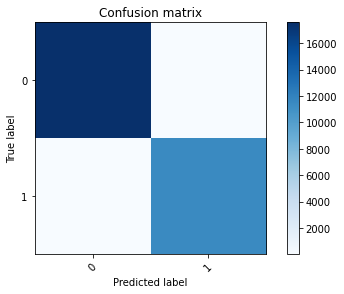

Accuracy: 0.9985575437029914
Averaged F1: 0.9985575221365692
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Sigmoid, Optimizer = adam
## Layer 1 : 100 neurons
## Layer 2:  500 neurons

1 m

Accuracy: 0.9974928735790088
Averaged F1: 0.9974924408781408

0
Epoch 1/200
167/167 - 1s - loss: 0.0496 - accuracy: 0.9583 - val_loss: 0.0204 - val_accuracy: 0.9839

Epoch 00001: val_loss improved from inf to 0.02036, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0185 - accuracy: 0.9835 - val_loss: 0.0186 - val_accuracy: 0.9831

Epoch 00002: val_loss improved from 0.02036 to 0.01865, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0160 - accuracy: 0.9837 - val_loss: 0.0160 - val_accuracy: 0.9842

Epoch 00003: val_loss improved from 0.01865 to 0.01603, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0144 - accuracy: 0.9836 - val_loss: 0.0138 - val_accuracy: 0.9840

Epoch 00004: val_loss improved from 0.01603 to 0.01375, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0136 - accuracy: 0.9837 - val_loss: 0.0129 - val_accuracy: 0.9841

Epoch 00005: val_loss improved from 0.01375 to 0.01285, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

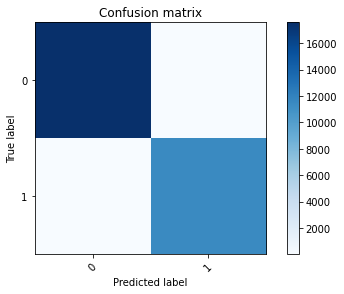

Accuracy: 0.9974928735790088
Averaged F1: 0.9974924408781408
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='sigmoid'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Relu, Optimizer = sgd
## Layer 1 : 100 neurons
## Layer 2:  500 neurons

1 m

Accuracy: 0.9837208503623313
Averaged F1: 0.9836845243872174



0
Epoch 1/200
167/167 - 1s - loss: 0.0798 - accuracy: 0.9477 - val_loss: 0.0373 - val_accuracy: 0.9633

Epoch 00001: val_loss improved from inf to 0.03730, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0341 - accuracy: 0.9648 - val_loss: 0.0318 - val_accuracy: 0.9646

Epoch 00002: val_loss improved from 0.03730 to 0.03179, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0301 - accuracy: 0.9652 - val_loss: 0.0288 - val_accuracy: 0.9648

Epoch 00003: val_loss improved from 0.03179 to 0.02875, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0276 - accuracy: 0.9655 - val_loss: 0.0266 - val_accuracy: 0.9649

Epoch 00004: val_loss improved from 0.02875 to 0.02661, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0257 - accuracy: 0.9659 - val_loss: 0.0250 - val_accuracy: 0.9660

Epoch 00005: val_loss improved from 0.02661 to 0.02499, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

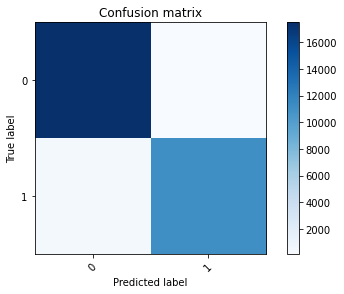

Accuracy: 0.9837208503623313
Averaged F1: 0.9836845243872174
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17589
           1       0.99      0.97      0.98     11528

    accuracy                           0.98     29117
   macro avg       0.99      0.98      0.98     29117
weighted avg       0.98      0.98      0.98     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Tanh, Optimizer = sgd
## Layer 1 : 100 neurons
## Layer 2:  500 neurons
1 m

Accuracy: 0.985128962461792
Averaged F1: 0.9851017369243829



0
Epoch 1/200
167/167 - 1s - loss: 0.0780 - accuracy: 0.9332 - val_loss: 0.0358 - val_accuracy: 0.9681

Epoch 00001: val_loss improved from inf to 0.03583, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0324 - accuracy: 0.9683 - val_loss: 0.0297 - val_accuracy: 0.9687

Epoch 00002: val_loss improved from 0.03583 to 0.02966, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0280 - accuracy: 0.9686 - val_loss: 0.0264 - val_accuracy: 0.9690

Epoch 00003: val_loss improved from 0.02966 to 0.02640, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0254 - accuracy: 0.9691 - val_loss: 0.0242 - val_accuracy: 0.9694

Epoch 00004: val_loss improved from 0.02640 to 0.02422, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0236 - accuracy: 0.9700 - val_loss: 0.0226 - val_accuracy: 0.9709

Epoch 00005: val_loss improved from 0.02422 to 0.02261, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

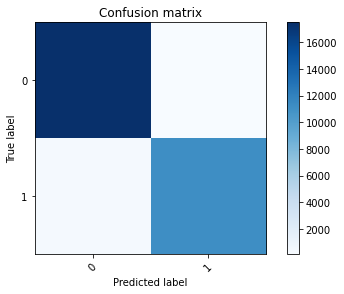

Accuracy: 0.985128962461792
Averaged F1: 0.9851017369243829
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     17589
           1       0.99      0.97      0.98     11528

    accuracy                           0.99     29117
   macro avg       0.99      0.98      0.98     29117
weighted avg       0.99      0.99      0.99     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

## Activation = Sigmoid, Optimizer = sgd
## Layer 1 : 100 neurons
## Layer 2:  500 neurons
2 mins

Accuracy: 0.9715630044304014

Averaged F1: 0.9713849954645342




0
Epoch 1/200
167/167 - 1s - loss: 0.1716 - accuracy: 0.7973 - val_loss: 0.1119 - val_accuracy: 0.9653

Epoch 00001: val_loss improved from inf to 0.11191, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0765 - accuracy: 0.9655 - val_loss: 0.0519 - val_accuracy: 0.9679

Epoch 00002: val_loss improved from 0.11191 to 0.05186, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0440 - accuracy: 0.9680 - val_loss: 0.0397 - val_accuracy: 0.9679

Epoch 00003: val_loss improved from 0.05186 to 0.03969, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0381 - accuracy: 0.9680 - val_loss: 0.0369 - val_accuracy: 0.9680

Epoch 00004: val_loss improved from 0.03969 to 0.03689, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0360 - accuracy: 0.9680 - val_loss: 0.0353 - val_accuracy: 0.9680

Epoch 00005: val_loss improved from 0.03689 to 0.03529, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

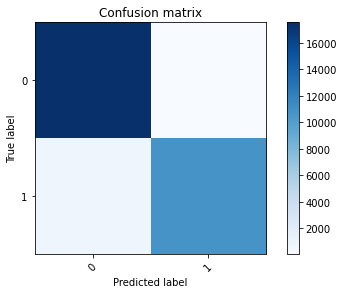

Accuracy: 0.9715630044304014
Averaged F1: 0.9713849954645342
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17589
           1       1.00      0.93      0.96     11528

    accuracy                           0.97     29117
   macro avg       0.98      0.96      0.97     29117
weighted avg       0.97      0.97      0.97     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='sigmoid'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

# Testing on differnet numbers of layer and neuron
activation = relu, optimizer = adam

100 neuroins on first layer, 500 neuroins on second layer

### 10 neurons per layer, add 1 more hidden layers
41s

Accuracy: 0.9986605762956349
Averaged F1: 0.998660606307565

0
Epoch 1/200
167/167 - 1s - loss: 0.0249 - accuracy: 0.9752 - val_loss: 0.0079 - val_accuracy: 0.9913

Epoch 00001: val_loss improved from inf to 0.00786, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0062 - accuracy: 0.9919 - val_loss: 0.0044 - val_accuracy: 0.9938

Epoch 00002: val_loss improved from 0.00786 to 0.00444, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0036 - accuracy: 0.9963 - val_loss: 0.0026 - val_accuracy: 0.9981

Epoch 00003: val_loss improved from 0.00444 to 0.00264, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0022 - accuracy: 0.9981 - val_loss: 0.0018 - val_accuracy: 0.9980

Epoch 00004: val_loss improved from 0.00264 to 0.00183, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0017 - accuracy: 0.9984 - val_loss: 0.0015 - val_accuracy: 0.9984

Epoch 00005: val_loss improved from 0.00183 to 0.00148, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

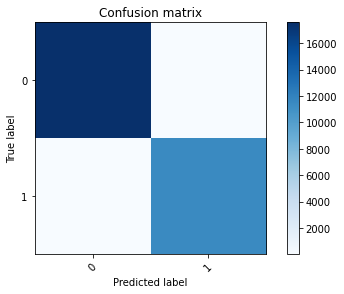

Accuracy: 0.9986605762956349
Averaged F1: 0.998660606307565
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

### 100 neurons per layer, add 1 more hidden layers
43s

Accuracy: 0.9987979530858262
Averaged F1: 0.9987979081315314

0
Epoch 1/200
167/167 - 1s - loss: 0.0201 - accuracy: 0.9847 - val_loss: 0.0063 - val_accuracy: 0.9919

Epoch 00001: val_loss improved from inf to 0.00632, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0051 - accuracy: 0.9939 - val_loss: 0.0037 - val_accuracy: 0.9963

Epoch 00002: val_loss improved from 0.00632 to 0.00372, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0027 - accuracy: 0.9978 - val_loss: 0.0018 - val_accuracy: 0.9985

Epoch 00003: val_loss improved from 0.00372 to 0.00184, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0019 - accuracy: 0.9983 - val_loss: 0.0016 - val_accuracy: 0.9984

Epoch 00004: val_loss improved from 0.00184 to 0.00159, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0016 - accuracy: 0.9985 - val_loss: 0.0015 - val_accuracy: 0.9985

Epoch 00005: val_loss improved from 0.00159 to 0.00146, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

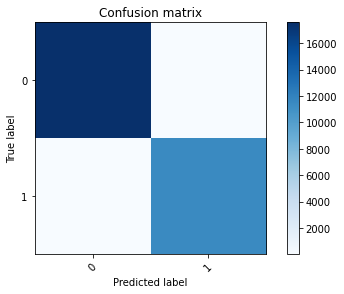

Accuracy: 0.9987979530858262
Averaged F1: 0.9987979081315314
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

model.summary()

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

### 500 neurons per layer, add 1 more hidden layers
41s

Accuracy: 0.9987292646907305
Averaged F1: 0.9987293310795642

0
Epoch 1/200
167/167 - 1s - loss: 0.0168 - accuracy: 0.9836 - val_loss: 0.0054 - val_accuracy: 0.9931

Epoch 00001: val_loss improved from inf to 0.00537, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0038 - accuracy: 0.9959 - val_loss: 0.0022 - val_accuracy: 0.9984

Epoch 00002: val_loss improved from 0.00537 to 0.00222, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0020 - accuracy: 0.9981 - val_loss: 0.0018 - val_accuracy: 0.9985

Epoch 00003: val_loss improved from 0.00222 to 0.00177, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0017 - accuracy: 0.9984 - val_loss: 0.0016 - val_accuracy: 0.9984

Epoch 00004: val_loss improved from 0.00177 to 0.00155, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0016 - accuracy: 0.9985 - val_loss: 0.0014 - val_accuracy: 0.9986

Epoch 00005: val_loss improved from 0.00155 to 0.00139, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

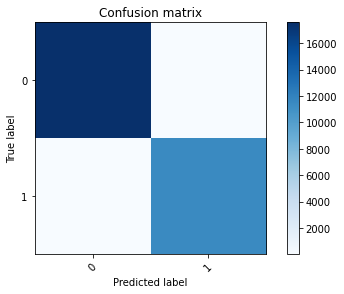

Accuracy: 0.9987292646907305
Averaged F1: 0.9987293310795642
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

### 10 neurons per layer, add 2 more hidden layers
57s

Accuracy: 0.9987292646907305
Averaged F1: 0.998729217167619


0
Epoch 1/200
167/167 - 1s - loss: 0.0239 - accuracy: 0.9808 - val_loss: 0.0076 - val_accuracy: 0.9903

Epoch 00001: val_loss improved from inf to 0.00757, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0058 - accuracy: 0.9927 - val_loss: 0.0034 - val_accuracy: 0.9961

Epoch 00002: val_loss improved from 0.00757 to 0.00340, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0028 - accuracy: 0.9975 - val_loss: 0.0019 - val_accuracy: 0.9981

Epoch 00003: val_loss improved from 0.00340 to 0.00192, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0020 - accuracy: 0.9979 - val_loss: 0.0017 - val_accuracy: 0.9982

Epoch 00004: val_loss improved from 0.00192 to 0.00169, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0017 - accuracy: 0.9982 - val_loss: 0.0019 - val_accuracy: 0.9981

Epoch 00005: val_loss did not improve from 0.00169
Epoch 6/200
167/167 - 1s - loss: 0.0016 - accuracy: 0.9983 - val_

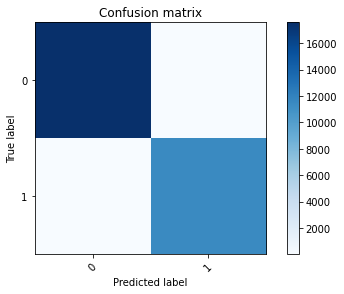

Accuracy: 0.9987292646907305
Averaged F1: 0.998729217167619
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

### 100 neurons per layer, add 2 more hidden layers
31s

Accuracy: 0.9985575437029914
Averaged F1: 0.9985575437029914

0
Epoch 1/200
167/167 - 1s - loss: 0.0203 - accuracy: 0.9819 - val_loss: 0.0059 - val_accuracy: 0.9922

Epoch 00001: val_loss improved from inf to 0.00588, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0043 - accuracy: 0.9951 - val_loss: 0.0024 - val_accuracy: 0.9984

Epoch 00002: val_loss improved from 0.00588 to 0.00237, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0021 - accuracy: 0.9981 - val_loss: 0.0017 - val_accuracy: 0.9980

Epoch 00003: val_loss improved from 0.00237 to 0.00165, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0016 - accuracy: 0.9983 - val_loss: 0.0016 - val_accuracy: 0.9983

Epoch 00004: val_loss improved from 0.00165 to 0.00163, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.0015 - val_accuracy: 0.9981

Epoch 00005: val_loss improved from 0.00163 to 0.00149, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

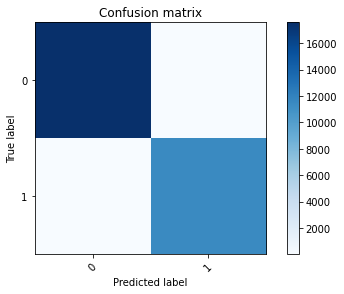

Accuracy: 0.9985575437029914
Averaged F1: 0.9985575437029914
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

### 500 neurons per layer, add 2 more hidden layers
54s

Accuracy: 0.9985231995054435
Averaged F1: 0.9985232105394404

0
Epoch 1/200
167/167 - 2s - loss: 0.0160 - accuracy: 0.9845 - val_loss: 0.0057 - val_accuracy: 0.9945

Epoch 00001: val_loss improved from inf to 0.00565, saving model to dnn/best_weights.hdf5
Epoch 2/200
167/167 - 1s - loss: 0.0033 - accuracy: 0.9967 - val_loss: 0.0022 - val_accuracy: 0.9980

Epoch 00002: val_loss improved from 0.00565 to 0.00224, saving model to dnn/best_weights.hdf5
Epoch 3/200
167/167 - 1s - loss: 0.0020 - accuracy: 0.9982 - val_loss: 0.0015 - val_accuracy: 0.9985

Epoch 00003: val_loss improved from 0.00224 to 0.00148, saving model to dnn/best_weights.hdf5
Epoch 4/200
167/167 - 1s - loss: 0.0016 - accuracy: 0.9984 - val_loss: 0.0014 - val_accuracy: 0.9983

Epoch 00004: val_loss improved from 0.00148 to 0.00144, saving model to dnn/best_weights.hdf5
Epoch 5/200
167/167 - 1s - loss: 0.0015 - accuracy: 0.9985 - val_loss: 0.0013 - val_accuracy: 0.9986

Epoch 00005: val_loss improved from 0.00144 to 0.00126, saving model to dnn/best_weights.hdf5
Epoch 6/200
167/167 - 

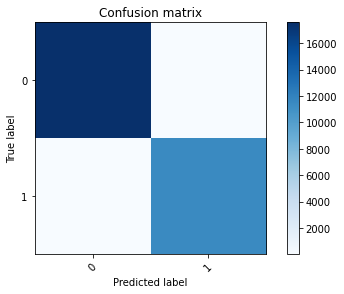

Accuracy: 0.9985231995054435
Averaged F1: 0.9985232105394404
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17589
           1       1.00      1.00      1.00     11528

    accuracy                           1.00     29117
   macro avg       1.00      1.00      1.00     29117
weighted avg       1.00      1.00      1.00     29117



In [ ]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=1, save_best_only=True) # save best model


for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train, y_train, batch_size=700, epochs=200, verbose=2, callbacks=[monitor, checkpointer], validation_data=(x_test, y_test))
    # model.summary()

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

y_true = np.argmax(y_test,axis=1)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))